In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np

import plots
from ConsumptionSavingModel import ConsumptionSavingModelClass

# Solving the buffer-stock consumption model

Consider the canonical buffer-stock consumption model:

Bellman equation in ratio form: 

$$\begin{align*}
v_{t}(m_{t}) & = \max_{c_{t}}\left\{ \frac{c_{t}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[(G L_{t+1} \psi_{t+1})^{1-\rho}v_{t+1}(m_{t+1})\right]\right\} \\
 & \text{s.t.}\\
 a_t & =  m_t-c_t \\
m_{t+1} & =  \frac{1}{G L_t \psi_{t+1}}Ra_t+\xi_{t+1}\\ 
\psi_{t} & \sim  \exp \mathcal{N}(-0.5 \sigma^2_{\psi},\sigma^2_{\psi})\\
\xi_{t} & \sim  \exp \mathcal{N}(-0.5 \sigma^2_{\xi},\sigma^2_{\xi}) \\
\end{align*}$$

and remember
$$\begin{align*}
Y_{t+1}& = \psi_{t+1} P_{t+1} \\
P_{t+1}& = GL_tP_t\psi_{t+1}\\ 
c_t & \equiv C_t/P_t \\
m_t & \equiv M_t/P_t \\
a_t & \equiv A_t/P_t \\
p_t & \equiv \ln(P_t) \\
y_t & \equiv \ln(Y_t) \\
\end{align*}$$



In [2]:
#Load baseline settings
model = ConsumptionSavingModelClass()

#Solve and simulate
model.precompile_numba()
model.solve()
model.simulate()

par = model.par
sol = model.sol
sim = model.sim

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


model simulated in 0.6 secs
model simulated in 4.5 secs


In [3]:
sol.c

array([[ 0.        ,  0.94932785,  0.98204313, ...,  1.51237096,
         1.52476455,  1.53892828],
       [ 0.        ,  0.94664692,  0.97822848, ...,  1.50673895,
         1.51919677,  1.53343412],
       [ 0.        ,  0.94374947,  0.97410185, ...,  1.50147329,
         1.51400008,  1.52831642],
       ...,
       [ 0.        ,  1.00303883,  1.04138012, ...,  6.48027143,
         6.61979406,  6.77934474],
       [ 0.        ,  1.00303983,  1.07554165, ..., 11.77891228,
        12.0534834 , 12.36746835],
       [ 0.        ,  0.06940531,  0.13913939, ..., 10.43391189,
        10.69800133, 11.        ]])

#### Plots

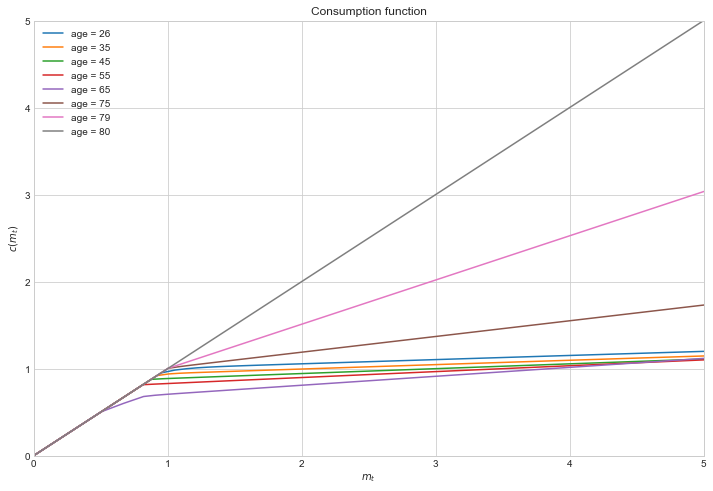

In [4]:
plots.plot_consumption(sol,par)

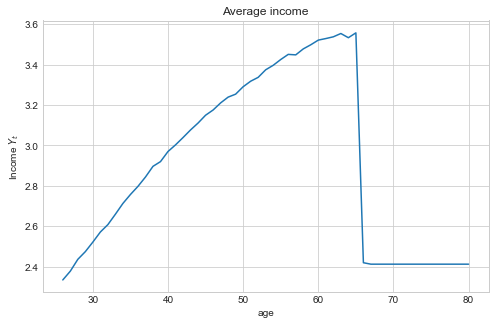

In [5]:
plots.plot_avg_income(sim,par)

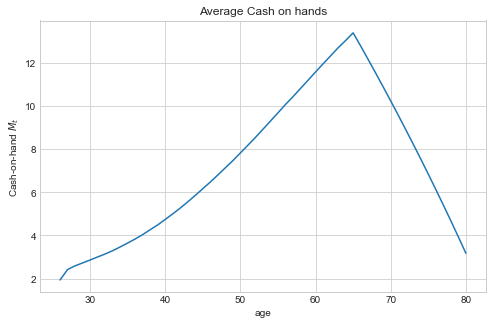

In [6]:
plots.plot_avg_cash_on_hand(sim,par)

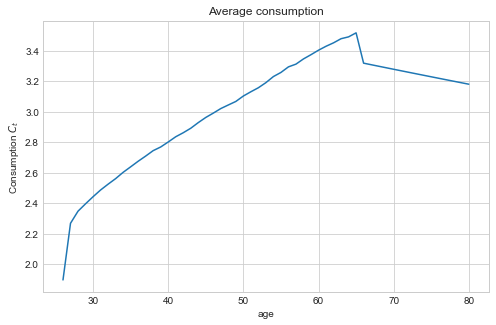

In [7]:
plots.plot_avg_consumption(sim,par)

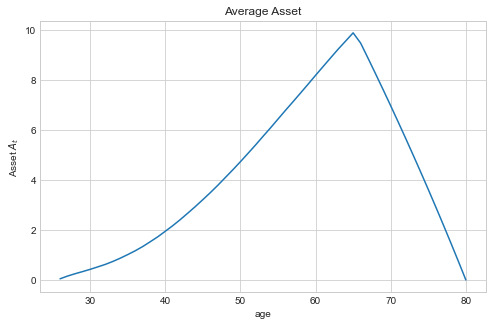

In [9]:
plots.plot_avg_assets(sim,par)

In [10]:
np.mean(sim.mpc,1)

array([0.82719682, 0.4043509 , 0.33150603, 0.25751886, 0.18989041,
       0.15592168, 0.12969813, 0.10503399, 0.08622505, 0.07392573,
       0.06700953, 0.06191587, 0.05845739, 0.0564403 , 0.05560482,
       0.05460719, 0.05511286, 0.05558892, 0.056018  , 0.05649815,
       0.05721916, 0.05800998, 0.05887601, 0.05982481, 0.06086369,
       0.06200241, 0.0632528 , 0.06463133, 0.06615497, 0.06783491,
       0.06970769, 0.07178933, 0.074125  , 0.0767487 , 0.07971808,
       0.08309509, 0.0869637 , 0.09143525, 0.09664953, 0.10279899,
       0.08292702, 0.08752602, 0.09284569, 0.09906623, 0.10643337,
       0.11529114, 0.12613645, 0.13971467, 0.1571971 , 0.18053589,
       0.2132449 , 0.26235186, 0.34425474, 0.50814753, 1.        ])

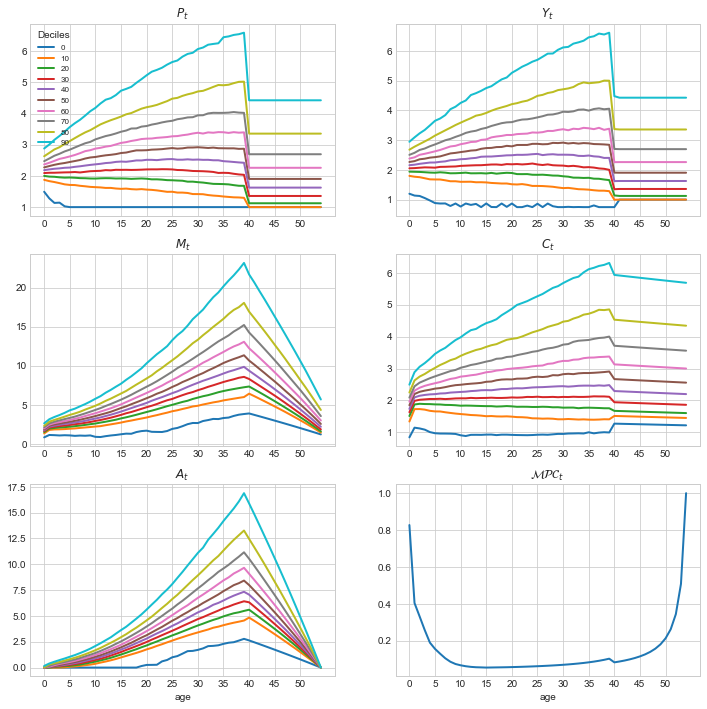

In [11]:
plots.lifecycle(par,sim,deciles=True)

<AxesSubplot:>

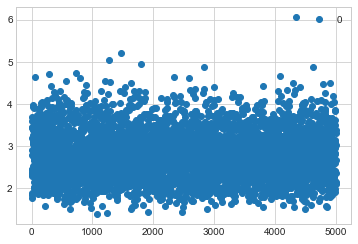

In [123]:
import pandas as pd
pd.DataFrame(sim.m0).plot(style='o')

In [12]:
from consav.grids import nonlinspace
import matplotlib.pyplot as plt
from consav import linear_interp

# plot mpc as a function of cash-on-hand for given t
p_bar = np.mean(sim.p,axis=1)
n_bar = np.mean(sim.n,axis=1)

c0 = np.zeros(shape=(par.T, len(par.grid_m)))
c1 = np.zeros(shape=(par.T, len(par.grid_m)))
mpc = np.zeros(shape=(par.T, len(par.grid_m)))

m_grid =  nonlinspace(0,par.m_max,par.Nm,1.1) # par.grid_m

for t in range(par.T):
    t = int(t)    
    for m in m_grid:
        m = int(m)
        c0[t,m] = linear_interp.interp_3d(
                par.grid_p,par.grid_n,par.grid_m,sol.c_keep[t],
                p_bar[t],n_bar[t],m)
        c1[t,m] = linear_interp.interp_3d(
                par.grid_p,par.grid_n,par.grid_m,sol.c_keep[t],
                p_bar[t],n_bar[t],m+par.mpc_eps)
        mpc[t,m] = (c1[t,m]-c0[t,m])/par.mpc_eps

plt.figure(figsize=(12,8))
for t in np.arange(5,par.T,5):
    plt.plot(par.grid_m,mpc[t,:],label='t={}'.format(t))
plt.xlim(0,1)
plt.xlabel('Cash-on-hand, $m_t$')
plt.ylabel('$\mathcal{MPC}_t$')
plt.title('$\mathcal{MPC}$ as a function of cash-on-hand (Keep-problem)')
plt.legend()
plt.show()

AttributeError: 'types.SimpleNamespace' object has no attribute 'n'

In [18]:
plots.mpc_over_cash_on_hand(model)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed